In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, MeanShift, SpectralClustering, KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

from get_nice_text import *

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

Do feature engineering spróbowaliśmy następujących podejść:
 * stop_words - usunięcie z kolumn słów pokroju "the", "and" itp.
 * entities - encja, reprezentująca @TODO nie wiem jak to ładnie opisać
 * słownika nlp - biblioteka, która zawiera własny słownik, wyodrębniający słowa z tekstu
 * TfidfTransformer - skaluje wystąpienia biorąc pod uwagę wystąpienia w całym tekście, by uwzględnić wagę i częstotliwość danego słowa
 * lematyzacja - sprowadzanie słów do ich podstawowego słowa, np. kotek -> kot, mierzyła -> miara
 * stemming - usuwanie końcówek fleksyjnych
 * usuwanie kolumn o niskiej wariancji
 
 
@TODO
 * redukcja wymiarów przy pomocy tsne i porównanie z początkowym stanem(po prostu kolory dać wg labels)

Część metod nie polepszyła wyników, a niektóre nawet znacznie je obniżyła. Ostatecznie zdecydowaliśmy się na wykorzystanie stop-words z angielskiego słownika oraz TfidfTransformer z sklearn.

## Przykładowy model

In [13]:
def train_fast(df, Model, labels, **kwargs):
    """
    Trenuje Model na sparse matrix df
    @example
    train fast(df, KMeans, n_clusters=8)
    """
    trans = TfidfTransformer()
    df_trans = trans.fit_transform(df)
    model = Model(**kwargs)
    lab = model.fit_predict(df_trans)
    
    ret = {}
    
    ret["homogeneity_score"] = homogeneity_score(labels, lab)
    ret["completeness_score"] = completeness_score(labels, lab)
    ret["v_measure_score"] = v_measure_score(labels, lab)
    

    return lab, ret, model

In [9]:
df = get_nice_text()
np.random.seed(123)

cv = CountVectorizer()
df_count = cv.fit_transform(df)

lab, scores, m = train_fast(df_count, KMeans, get_labels(True), n_clusters=5, random_state = 123)
scores

{'homogeneity_score': 0.5504130721916395,
 'completeness_score': 0.5575716186373115,
 'v_measure_score': 0.5539692201909778}

## Przetestowane modele

 * KMeans
 * MiniBatchKMeans
 * DBSCAN
 * Birch
 * AgglomerativeClustering
 * SpectralClustering
 * GaussianMixture
 
 Do testowania wyników modeli użyliśmy specjanie stworzonej przez nas funkcji fast_GridSearch, która umożliwia nam przetestowanie wielu różnych modeli z różnymi parametrami.

# < tu obluiczenia z gridsearchfast>

# Biblia czy księgi?
Na początku projektu postawiliśmny hipotezę, iż łączenie ksiąg bilblijnych w jedną klasę 'Biblia' sprawi, iż modele będą osiągały lepsze wyniki. Mając wytrenowane modele dla obu wariantów możemy porównać te wyniki i jasno potwierdzić lub obalić hipotezę.

Spójrzmy jednak najpierw na dobrze nam znany łokieć oraz silhouette_score dla najbardziej trywialnego algorytmu - KMeans:

In [17]:
np.random.seed(123)
l = []
s = []
for i in range(2,11):
    lab, ret, m = train_fast(df_count, KMeans, get_labels(True), random_state = 123, n_clusters = i)
    l.append(m.inertia_)
    s.append(silhouette_score(df_count, lab))

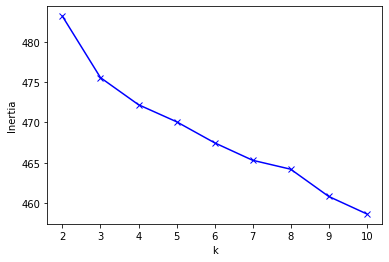

In [18]:
plt.plot(range(2,11), l, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

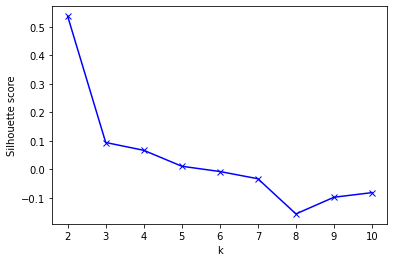

In [19]:
plt.plot(range(2,11), s, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Porównajmy teraz wyniki z naszych modeli:

In [1]:
#@chuj zrobie rano 
#results_table5.loc["score"]
# różnica średnich wyników dla n =5, n=8, może jakaś gęstość??? to by było ładne

NameError: name 'results_table5' is not defined

# Wnioski

* Najlepszym modelem okazał się ___
* Początkowa hipoteza, iż połączenie wszystkich księg Bibli i oznaczenie jej jako jednej klasy będzie wspomagało modele okazała się nieprawdziwa - modele osiągały lepsze wyniki gdy każda księga Bibli była traktowana jako oddzielna klasa
* NLP jest rozległą i skomplikowaną dziedziną, której nie sposób "ot tak" zaimplementować. Trzeba przyłożyć do niej dużo uwagi i wiedzy, by móc w niej działać.